<a href="https://colab.research.google.com/github/kubernetes-world/3666-ANLP-Predicting-ECB-Monetary-Policy/blob/main/Final%20Project%20-%20LSTM-SMOTE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install diskcache
!pip install boto3
!pip install scikeras

In [ ]:
import os
import pandas as pd
import numpy as np

import unicodedata

from itertools import groupby
from unicodedata import category as unicat

import nltk
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

from nltk import word_tokenize, pos_tag
from nltk.chunk import tree2conlltags
from nltk.chunk.regexp import RegexpParser
from nltk.corpus import wordnet as wn
from nltk.probability import FreqDist
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import sent_tokenize

from sklearn.base import BaseEstimator, TransformerMixin

from tensorflow.keras.utils import pad_sequences

# Download cleaned data prepared in previous notebooks

In [7]:
from google.colab import userdata
import boto3

s3 = boto3.client("s3", aws_access_key_id=userdata.get('AWS_ACCESS_KEY_ID'), aws_secret_access_key=userdata.get('AWS_SECRET_ACCESS_KEY'))
s3.download_file("3666-applied-nlp", "KeyphraseExtractor.cache.tar.gz", "KeyphraseExtractor.cache.tar.gz")
s3.download_file("3666-applied-nlp", "rate_speeches.sent_tokenize.parquet.gzip", "rate_speeches.sent_tokenize.parquet.gzip")


In [8]:

RATE_SPEECHES_TOKENIZED_FILE = 'rate_speeches.sent_tokenize.parquet.gzip'
assert os.path.exists(RATE_SPEECHES_TOKENIZED_FILE), f"file not present: {RATE_SPEECHES_TOKENIZED_FILE}"

rate_speeches = pd.read_parquet(RATE_SPEECHES_TOKENIZED_FILE)
print(f"rate_speeches.shape: {rate_speeches.shape}")


rate_speeches.shape: (3434, 17)


In [ ]:
!tar zxvf KeyphraseExtractor.cache.tar.gz

In [10]:

from diskcache import Cache
cache = Cache('KeyphraseExtractor.cache')


# `KeyphraseExtractor` transformer

In [11]:
# from joblib import Memory
# location = 'keyphrase_extractor_cachedir'
# memory = Memory(location, verbose=0)

from tqdm import tqdm

class KeyphraseExtractor(BaseEstimator, TransformerMixin):
    """
    Extract adverbial and adjective phrases, and transform
    documents into lists of these keyphrases, with a total
    keyphrase lexicon limited by the nfeatures parameter
    and a document length limited/padded to doclen
    """
    def __init__(self, nfeatures: int, doclen: int):
        self.grammar = r'KT: {(<RB.> <JJ.*>|<VB.*>|<RB.*>)|(<JJ> <NN.*>)}'
        # self.grammar = r'KT: {(<RB.*> <VB.>|<RB.>|<JJ.> <NN.*>)}'
        # self.grammar = r'KT: {<RB.>|<JJ.>}'
        self.chunker = RegexpParser(self.grammar)
        self.nfeatures = nfeatures
        self.doclen = doclen
        # self.normalize = memory.cache(self.normalize)
        # self.extract_candidate_phrases = memory.cache(self.extract_candidate_phrases)

    def normalize(self, sent):
        """
        Removes punctuation from a tokenized/tagged sentence and
        lowercases words.
        """
        is_punct = lambda word: all(unicat(c).startswith('P') for c in word)
        sent = filter(lambda t: not is_punct(t[0]), sent)
        sent = map(lambda t: (t[0].lower(), t[1]), sent)
        return list(sent)

    # NOTE: wrap with memoizing function using cache
    # repeated calls with the same arguments will lookup result in cache and avoid function evaluation.
    @cache.memoize()
    def extract_candidate_phrases(self, sents):
        """
        For a document, parse sentences using our chunker created by
        our grammar, converting the parse tree into a tagged sequence.
        Extract phrases, rejoin with a space, and yield the document
        represented as a list of it's keyphrases.
        """
        result = []
        for sent in sents:
            tokens = word_tokenize(sent)
            pos_tags = pos_tag(tokens)
            normalized = self.normalize(pos_tags)

            chunks = tree2conlltags(self.chunker.parse(normalized))
            if not chunks or all(chunk[-1] == 'O' for chunk in chunks):
                # print(f"No valid chunks found in sentence: {sent}")
                continue

            phrases = [
                " ".join(word for word, pos, chunk in group).lower()
                for key, group in groupby(
                    chunks, lambda term: term[-1] != 'O'
                ) if key
            ]
            for phrase in phrases:
                # yield phrase # joblib.Memory can't cache generators
                result.append(phrase)
        return result

    def fit(self, documents, y=None):
        return self

    def get_lexicon(self, keydocs):
        """
        Build a lexicon of size nfeatures
        """
        keyphrases = [keyphrase for doc in keydocs for keyphrase in doc]
        # print("Keyphrases:", keyphrases[:5])
        fdist = FreqDist(keyphrases)
        counts = fdist.most_common(self.nfeatures)
        # print("Frequency counts:", counts[:5])
        lexicon = [phrase for phrase, count in counts]
        return {phrase: idx+1 for idx, phrase in enumerate(lexicon)}

    def clip(self, keydoc, lexicon):
        """
        Remove keyphrases from documents that aren't in the lexicon
        """
        return [lexicon[keyphrase] for keyphrase in keydoc if keyphrase in lexicon.keys()]

    def transform(self, documents):
      keydocs = [list(self.extract_candidate_phrases(doc)) for doc in tqdm(documents)]
      lexicon = self.get_lexicon(keydocs)
      clipped = [list(self.clip(keydoc, lexicon)) for keydoc in keydocs]
      return pad_sequences(clipped, maxlen=self.doclen)


### Build `KeyphraseExtractor.cache` (skip)

In [12]:
%%script false --no-raise-error

# build cache
keyphrase_extractor = KeyphraseExtractor(nfeatures=10000, doclen=100)
keyphrase_extractor.fit_transform(X)

# ---

from google.colab import userdata
import boto3

s3 = boto3.client("s3", aws_access_key_id=userdata.get('AWS_ACCESS_KEY_ID'), aws_secret_access_key=userdata.get('AWS_SECRET_ACCESS_KEY'))
s3.upload_file("KeyphraseExtractor.cache.tar.gz", "3666-applied-nlp", "KeyphraseExtractor.cache.tar.gz")

# ---

!tar -cvzf KeyphraseExtractor.cache.tar.gz KeyphraseExtractor.cache


# LSTM model

In [13]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dropout, Dense, Input

def create_lstm_model(vocab_size: int, input_length: int, num_classes: int, compile_loss: str):
    model = Sequential([
        Input(shape=(input_length,), name="input_layer"),  # explicit input layer
        Embedding(input_dim=vocab_size, output_dim=128, name="embedding_layer"),
        LSTM(128, return_sequences=True, name="lstm_layer_1"),
        Dropout(0.2, name="dropout_layer_1"),
        LSTM(64, name="lstm_layer_2"),
        Dropout(0.2, name="dropout_layer_2"),
        Dense(num_classes, activation="softmax", name="output_layer")
    ])
    model.compile(optimizer='adam', loss=compile_loss, metrics=['accuracy'])
    return model


In [14]:
class DebugTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        print(f"LSTM X.shape: {X.shape}")
        # print(f"Sample Data Before LSTM: {X[0]}")  # print a sample
        return X

# Label encoding and train/test splitting

## No Data Leakage

- It is acceptable to call `label_encoder.fit_transform(..)` on the entire set of labels (`rate_speeches["Direction"]`) prior to splitting because `LabelEncoder` is a simple transformation that maps categorical values to numerical labels.

- **It does not learn any information about the dataset beyond the unique classes.**


In [26]:
from sklearn.preprocessing import LabelEncoder

X = rate_speeches["extracted_text"]
print(f"X.shape: {X.shape}")

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(rate_speeches["Direction"])  # integer encoding
print(f"y_encoded.shape: {y_encoded.shape}")


X.shape: (3434,)
y_encoded.shape: (3434,)


In [27]:
from sklearn.model_selection import train_test_split, cross_val_score

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded)


# `StratifiedKFold` (and choice of `n_splits`)

## 5-Fold Cross-Validation:
- Most commonly used.
- Provides a good balance between bias and variance of the performance estimate.

## 10-Fold Cross-Validation:
- Preferred when data is limited and computational cost is acceptable.
- Offers slightly more robust performance estimates but increases computation time.

In [28]:
from sklearn.model_selection import StratifiedKFold

# dynamically determine n_splits based on class distribution
min_class_size = rate_speeches["Direction"].value_counts().min()
print(f"min_class_size: {min_class_size}")

n_splits = min(10, min_class_size)  # use up to 10 splits or the smallest class size
print(f"Using {n_splits}-Fold Cross-Validation")

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)


min_class_size: 252
Using 10-Fold Cross-Validation


# Standard `sklearn.pipeline.Pipeline`

In [18]:
from sklearn.pipeline import Pipeline
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_validate

pipeline_scce = Pipeline([
    ("keyphrase_extractor",
      KeyphraseExtractor(nfeatures=10000, doclen=100)),
    ('debug', DebugTransformer()),
    ("lstm_classifier",
      KerasClassifier(
        build_fn=create_lstm_model,
        vocab_size=10000,
        input_length=100,
        num_classes=3,
        compile_loss='sparse_categorical_crossentropy',
        epochs=10,
        batch_size=32,
        verbose=1)
    )
])

scores_scce = cross_validate(
    pipeline_scce,
    X_train,
    y_train,
    cv=skf,
    scoring="accuracy",
    return_estimator=True,
    return_train_score=True)


100%|██████████| 2472/2472 [00:02<00:00, 1036.64it/s]


LSTM X.shape: (2472, 100)


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8134 - loss: 0.7079
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8359 - loss: 0.5021
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8975 - loss: 0.2390
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9639 - loss: 0.1182
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9859 - loss: 0.0556
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9985 - loss: 0.0165
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9973 - loss: 0.0160
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9991 - loss: 0.0048
Epoch 9/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9973 - loss: 0.0095
Epoch 10/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9986 - loss: 0.0051


100%|██████████| 275/275 [00:00<00:00, 1124.89it/s]


LSTM X.shape: (275, 100)
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


100%|██████████| 2472/2472 [00:02<00:00, 1097.55it/s]


LSTM X.shape: (2472, 100)
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


100%|██████████| 2472/2472 [00:02<00:00, 1112.50it/s]


LSTM X.shape: (2472, 100)
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7968 - loss: 0.6965
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8453 - loss: 0.4883
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9033 - loss: 0.2175
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9350 - loss: 0.1684
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9836 - loss: 0.0602
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9969 - loss: 0.0155
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9962 - loss: 0.0196
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9958 - loss: 0.0184
Epoch 9/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9982 - loss: 0.0091
Epoch 10/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9973 - loss: 0.0130


100%|██████████| 275/275 [00:00<00:00, 1101.07it/s]


LSTM X.shape: (275, 100)
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


100%|██████████| 2472/2472 [00:02<00:00, 1129.76it/s]


LSTM X.shape: (2472, 100)
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


100%|██████████| 2472/2472 [00:02<00:00, 1095.47it/s]


LSTM X.shape: (2472, 100)
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8254 - loss: 0.6717
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8351 - loss: 0.5002
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9174 - loss: 0.2165
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9716 - loss: 0.1004
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9843 - loss: 0.0587
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9923 - loss: 0.0289
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9967 - loss: 0.0121
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9985 - loss: 0.0079
Epoch 9/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9970 - loss: 0.0111
Epoch 10/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9968 - loss: 0.0136


100%|██████████| 275/275 [00:00<00:00, 1068.81it/s]


LSTM X.shape: (275, 100)
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


100%|██████████| 2472/2472 [00:02<00:00, 1125.18it/s]


LSTM X.shape: (2472, 100)
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


100%|██████████| 2472/2472 [00:02<00:00, 1106.17it/s]


LSTM X.shape: (2472, 100)
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8145 - loss: 0.6981
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8482 - loss: 0.4726
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8925 - loss: 0.2451
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9331 - loss: 0.1465
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9616 - loss: 0.0924
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9912 - loss: 0.0408
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9918 - loss: 0.0284
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9939 - loss: 0.0201
Epoch 9/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9970 - loss: 0.0084
Epoch 10/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9988 - loss: 0.0042


100%|██████████| 275/275 [00:00<00:00, 1104.90it/s]


LSTM X.shape: (275, 100)
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


100%|██████████| 2472/2472 [00:02<00:00, 1117.90it/s]


LSTM X.shape: (2472, 100)
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


100%|██████████| 2472/2472 [00:02<00:00, 1097.70it/s]


LSTM X.shape: (2472, 100)
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8186 - loss: 0.7054
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8508 - loss: 0.4629
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9131 - loss: 0.2161
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9713 - loss: 0.1130
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9920 - loss: 0.0379
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9968 - loss: 0.0155
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9968 - loss: 0.0206
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9975 - loss: 0.0141
Epoch 9/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9975 - loss: 0.0154
Epoch 10/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9990 - loss: 0.0088


100%|██████████| 275/275 [00:00<00:00, 1074.65it/s]


LSTM X.shape: (275, 100)
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


100%|██████████| 2472/2472 [00:02<00:00, 1129.27it/s]


LSTM X.shape: (2472, 100)
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


100%|██████████| 2472/2472 [00:02<00:00, 1115.20it/s]


LSTM X.shape: (2472, 100)
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8099 - loss: 0.7108
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8382 - loss: 0.4847
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8977 - loss: 0.2213
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9321 - loss: 0.1515
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9677 - loss: 0.0875
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9949 - loss: 0.0271
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9983 - loss: 0.0073
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9978 - loss: 0.0095
Epoch 9/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9993 - loss: 0.0048
Epoch 10/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9990 - loss: 0.0069


100%|██████████| 275/275 [00:00<00:00, 1111.16it/s]


LSTM X.shape: (275, 100)
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


100%|██████████| 2472/2472 [00:02<00:00, 1115.15it/s]


LSTM X.shape: (2472, 100)
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


100%|██████████| 2472/2472 [00:02<00:00, 1099.97it/s]


LSTM X.shape: (2472, 100)
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8168 - loss: 0.6899
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8462 - loss: 0.4802
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8948 - loss: 0.2265
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9347 - loss: 0.1433
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9837 - loss: 0.0776
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9950 - loss: 0.0281
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9956 - loss: 0.0259
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9954 - loss: 0.0123
Epoch 9/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9970 - loss: 0.0151
Epoch 10/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9929 - loss: 0.0223


100%|██████████| 275/275 [00:00<00:00, 946.76it/s]


LSTM X.shape: (275, 100)
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


100%|██████████| 2472/2472 [00:02<00:00, 1126.76it/s]


LSTM X.shape: (2472, 100)
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


100%|██████████| 2473/2473 [00:02<00:00, 1102.23it/s]


LSTM X.shape: (2473, 100)
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8016 - loss: 0.6873
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8391 - loss: 0.5048
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9160 - loss: 0.2218
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9861 - loss: 0.0554
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9983 - loss: 0.0142
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9955 - loss: 0.0216
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9990 - loss: 0.0045
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9984 - loss: 0.0083
Epoch 9/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9995 - loss: 0.0032
Epoch 10/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9992 - loss: 0.0040


100%|██████████| 274/274 [00:00<00:00, 1090.79it/s]


LSTM X.shape: (274, 100)
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


100%|██████████| 2473/2473 [00:02<00:00, 1099.81it/s]


LSTM X.shape: (2473, 100)
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


100%|██████████| 2473/2473 [00:02<00:00, 1114.53it/s]


LSTM X.shape: (2473, 100)
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7929 - loss: 0.7011
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8453 - loss: 0.4812
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9001 - loss: 0.2376
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9685 - loss: 0.0979
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9937 - loss: 0.0406
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9990 - loss: 0.0108
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9978 - loss: 0.0098
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9985 - loss: 0.0077
Epoch 9/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9940 - loss: 0.0230
Epoch 10/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9965 - loss: 0.0141


100%|██████████| 274/274 [00:00<00:00, 1146.71it/s]


LSTM X.shape: (274, 100)
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


100%|██████████| 2473/2473 [00:02<00:00, 1121.56it/s]


LSTM X.shape: (2473, 100)
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


100%|██████████| 2473/2473 [00:02<00:00, 1107.74it/s]


LSTM X.shape: (2473, 100)
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8236 - loss: 0.7072
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8460 - loss: 0.4953
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9028 - loss: 0.2473
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9361 - loss: 0.1582
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9794 - loss: 0.0668
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9910 - loss: 0.0375
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9942 - loss: 0.0291
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9983 - loss: 0.0122
Epoch 9/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9991 - loss: 0.0058
Epoch 10/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9970 - loss: 0.0102


100%|██████████| 274/274 [00:00<00:00, 1058.27it/s]


LSTM X.shape: (274, 100)
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


100%|██████████| 2473/2473 [00:02<00:00, 1126.20it/s]


LSTM X.shape: (2473, 100)
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [19]:
# print(scores_scce)
print(f"Cross-validation scores: {scores_scce['test_score']}")
print(f"Mean accuracy: {np.mean(scores_scce['test_score']):.2f}")

Cross-validation scores: [0.76       0.78181818 0.77818182 0.75272727 0.77818182 0.76
 0.79272727 0.82116788 0.78832117 0.81021898]
Mean accuracy: 0.78


## Model Evaluation

In [20]:

pipeline_scce.fit(X_train, y_train)
y_pred = pipeline_scce.predict(X_test)


100%|██████████| 2747/2747 [00:02<00:00, 1084.60it/s]


LSTM X.shape: (2747, 100)
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8087 - loss: 0.7194
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8559 - loss: 0.4735
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9244 - loss: 0.2263
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9753 - loss: 0.0866
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9900 - loss: 0.0395
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9960 - loss: 0.0179
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9988 - loss: 0.0071
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9979 - loss: 0.0066
Epoch 9/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9972 - loss: 0.0100
Epoch 10/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9988 - loss: 0.0033


100%|██████████| 687/687 [00:00<00:00, 1060.20it/s]


LSTM X.shape: (687, 100)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Confusion Matrix:
[[  3   4  52]
 [  2   1  47]
 [ 22  17 539]]



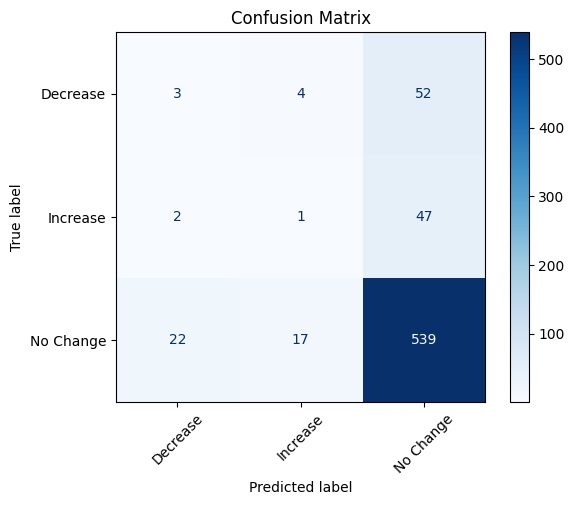


Classification Report:
              precision    recall  f1-score   support

    Decrease       0.11      0.05      0.07        59
    Increase       0.05      0.02      0.03        50
   No Change       0.84      0.93      0.89       578

    accuracy                           0.79       687
   macro avg       0.33      0.33      0.33       687
weighted avg       0.72      0.79      0.75       687



In [21]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred, labels=range(len(label_encoder.classes_)))
print(cm)

print()
# display Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

print()
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Synthetic Minority Over-sampling TEchnique (`SMOTE`) for imbalanced data

## Cross-Validation:

- Perform cross-validation with a pipeline to ensure that `SMOTE` is applied only on the training data in each fold.

## Use `imblearn.pipeline.Pipeline`:

- The `Pipeline` class in `imblearn` is specifically designed for scenarios where the pipeline modifies both X and y, such as oversampling with `SMOTE`.

## The `SMOTE` pipeline step:

- We place SMOTE after the `KeyphraseExtractor` preprocessing steps (as we would do with scaling or encoding) to ensure `SMOTE` operates on the transformed data.

## Avoiding data leakage:

- When using `Pipeline` with `SMOTE`, oversampling is applied only to the training folds during cross-validation.
- This avoids data leakage into the validation set, which would inflate performance metrics.


In [29]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_validate
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbalancedPipeline

imbalanced_pipeline = ImbalancedPipeline(steps=[
    ("keyphrase_extractor",
      KeyphraseExtractor(nfeatures=10000, doclen=100)),
    ("smote",
      SMOTE(random_state=42)),
    ('debug', DebugTransformer()),
    ("lstm_classifier",
      KerasClassifier(
        build_fn=create_lstm_model,
        vocab_size=10000,
        input_length=100,
        num_classes=3,
        compile_loss='sparse_categorical_crossentropy',
        epochs=10,
        batch_size=32,
        verbose=1))
])

scores = cross_validate(
    imbalanced_pipeline,
    X_train,
    y_train,
    cv=skf,
    scoring="accuracy",
    return_estimator=True,
    return_train_score=True)


100%|██████████| 2472/2472 [00:02<00:00, 1089.92it/s]


LSTM X.shape: (6237, 100)
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.4964 - loss: 0.9238
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6697 - loss: 0.6375
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8175 - loss: 0.4681
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9119 - loss: 0.2730
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9582 - loss: 0.1297
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9782 - loss: 0.0701
Epoch 7/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9834 - loss: 0.0465
Epoch 8/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9902 - loss: 0.0311
Epoch 9/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9906 - loss: 0.0289
Epoch 10/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9925 - loss: 0.0286


100%|██████████| 275/275 [00:00<00:00, 1105.76it/s]


LSTM X.shape: (275, 100)
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


100%|██████████| 2472/2472 [00:02<00:00, 1114.05it/s]


LSTM X.shape: (2472, 100)
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


100%|██████████| 2472/2472 [00:02<00:00, 1105.70it/s]


LSTM X.shape: (6237, 100)
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.4953 - loss: 0.9295
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6458 - loss: 0.6671
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7907 - loss: 0.4996
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8973 - loss: 0.2913
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9560 - loss: 0.1348
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9699 - loss: 0.0911
Epoch 7/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9800 - loss: 0.0601
Epoch 8/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9936 - loss: 0.0251
Epoch 9/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9957 - loss: 0.0150
Epoch 10/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9973 - loss: 0.0104


100%|██████████| 275/275 [00:00<00:00, 1108.85it/s]


LSTM X.shape: (275, 100)
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


100%|██████████| 2472/2472 [00:02<00:00, 1110.74it/s]


LSTM X.shape: (2472, 100)
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


100%|██████████| 2472/2472 [00:02<00:00, 1111.25it/s]


LSTM X.shape: (6237, 100)
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5077 - loss: 0.9191
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6888 - loss: 0.6415
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8370 - loss: 0.4312
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9232 - loss: 0.2264
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9511 - loss: 0.1350
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9840 - loss: 0.0541
Epoch 7/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9903 - loss: 0.0353
Epoch 8/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9945 - loss: 0.0161
Epoch 9/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9941 - loss: 0.0235
Epoch 10/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9911 - loss: 0.0252


100%|██████████| 275/275 [00:00<00:00, 1022.13it/s]


LSTM X.shape: (275, 100)
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


100%|██████████| 2472/2472 [00:02<00:00, 1098.48it/s]


LSTM X.shape: (2472, 100)
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


100%|██████████| 2472/2472 [00:02<00:00, 1099.71it/s]


LSTM X.shape: (6237, 100)
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.4948 - loss: 0.9213
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6727 - loss: 0.6432
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8052 - loss: 0.4639
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9104 - loss: 0.2610
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9571 - loss: 0.1362
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9780 - loss: 0.0837
Epoch 7/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9833 - loss: 0.0528
Epoch 8/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9826 - loss: 0.0575
Epoch 9/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9891 - loss: 0.0357
Epoch 10/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9900 - loss: 0.0279


100%|██████████| 275/275 [00:00<00:00, 1082.99it/s]


LSTM X.shape: (275, 100)
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


100%|██████████| 2472/2472 [00:02<00:00, 1117.66it/s]


LSTM X.shape: (2472, 100)
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


100%|██████████| 2472/2472 [00:02<00:00, 1094.03it/s]


LSTM X.shape: (6237, 100)
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5508 - loss: 0.8880
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7689 - loss: 0.5703
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8696 - loss: 0.3606
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9255 - loss: 0.2226
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9683 - loss: 0.1062
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9807 - loss: 0.0639
Epoch 7/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9889 - loss: 0.0329
Epoch 8/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9836 - loss: 0.0551
Epoch 9/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9888 - loss: 0.0350
Epoch 10/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9960 - loss: 0.0162


100%|██████████| 275/275 [00:00<00:00, 1044.74it/s]


LSTM X.shape: (275, 100)
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


100%|██████████| 2472/2472 [00:02<00:00, 1110.40it/s]


LSTM X.shape: (2472, 100)
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


100%|██████████| 2472/2472 [00:02<00:00, 1009.03it/s]


LSTM X.shape: (6237, 100)
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5235 - loss: 0.9162
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6691 - loss: 0.6339
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8190 - loss: 0.4720
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8961 - loss: 0.3085
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9510 - loss: 0.1562
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9732 - loss: 0.0793
Epoch 7/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9897 - loss: 0.0374
Epoch 8/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9925 - loss: 0.0263
Epoch 9/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9926 - loss: 0.0296
Epoch 10/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9923 - loss: 0.0257


100%|██████████| 275/275 [00:00<00:00, 1086.89it/s]


LSTM X.shape: (275, 100)
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


100%|██████████| 2472/2472 [00:02<00:00, 1086.11it/s]


LSTM X.shape: (2472, 100)
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


100%|██████████| 2472/2472 [00:02<00:00, 1093.00it/s]


LSTM X.shape: (6237, 100)
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5127 - loss: 0.9207
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6621 - loss: 0.6792
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7388 - loss: 0.5757
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8812 - loss: 0.3350
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9306 - loss: 0.2119
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9647 - loss: 0.1048
Epoch 7/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9769 - loss: 0.0796
Epoch 8/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9897 - loss: 0.0408
Epoch 9/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9858 - loss: 0.0441
Epoch 10/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9940 - loss: 0.0245


100%|██████████| 275/275 [00:00<00:00, 1107.86it/s]


LSTM X.shape: (275, 100)
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


100%|██████████| 2472/2472 [00:02<00:00, 1108.26it/s]


LSTM X.shape: (2472, 100)
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


100%|██████████| 2473/2473 [00:02<00:00, 1094.94it/s]


LSTM X.shape: (6237, 100)
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5294 - loss: 0.9265
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6238 - loss: 0.6696
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7518 - loss: 0.5462
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8808 - loss: 0.3516
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9499 - loss: 0.1764
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9739 - loss: 0.0875
Epoch 7/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9801 - loss: 0.0571
Epoch 8/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9945 - loss: 0.0225
Epoch 9/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9973 - loss: 0.0102
Epoch 10/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9926 - loss: 0.0254


100%|██████████| 274/274 [00:00<00:00, 1079.46it/s]


LSTM X.shape: (274, 100)
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


100%|██████████| 2473/2473 [00:02<00:00, 1111.78it/s]


LSTM X.shape: (2473, 100)
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


100%|██████████| 2473/2473 [00:02<00:00, 1104.51it/s]


LSTM X.shape: (6237, 100)
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5056 - loss: 0.9290
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6402 - loss: 0.6729
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7374 - loss: 0.5418
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8754 - loss: 0.3275
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9551 - loss: 0.1431
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9764 - loss: 0.0799
Epoch 7/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9785 - loss: 0.0669
Epoch 8/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9910 - loss: 0.0323
Epoch 9/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9937 - loss: 0.0173
Epoch 10/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9996 - loss: 0.0034


100%|██████████| 274/274 [00:00<00:00, 1123.21it/s]


LSTM X.shape: (274, 100)
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


100%|██████████| 2473/2473 [00:02<00:00, 1091.49it/s]


LSTM X.shape: (2473, 100)
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


100%|██████████| 2473/2473 [00:02<00:00, 1109.30it/s]


LSTM X.shape: (6237, 100)
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5224 - loss: 0.9191
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4753 - loss: 0.9815
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6856 - loss: 0.6742
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8460 - loss: 0.4207
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9190 - loss: 0.2408
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9627 - loss: 0.1224
Epoch 7/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9774 - loss: 0.0768
Epoch 8/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9846 - loss: 0.0520
Epoch 9/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9785 - loss: 0.0665
Epoch 10/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9917 - loss: 0.0296


100%|██████████| 274/274 [00:00<00:00, 1049.01it/s]


LSTM X.shape: (274, 100)
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


100%|██████████| 2473/2473 [00:02<00:00, 1113.82it/s]


LSTM X.shape: (2473, 100)
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [30]:
# print(scores)
print(f"Cross-validation scores: {scores['test_score']}")
print(f"Mean accuracy: {np.mean(scores['test_score']):.2f}")

Cross-validation scores: [0.54909091 0.53818182 0.57090909 0.49454545 0.54181818 0.54909091
 0.56727273 0.54744526 0.56934307 0.48175182]
Mean accuracy: 0.54


## Model Evaluation with `SMOTE`

In [31]:

imbalanced_pipeline.fit(X_train, y_train)
y_pred = imbalanced_pipeline.predict(X_test)


100%|██████████| 2747/2747 [00:02<00:00, 1072.14it/s]


LSTM X.shape: (6930, 100)
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


217/217 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5213 - loss: 0.9243
Epoch 2/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6968 - loss: 0.6485
Epoch 3/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8287 - loss: 0.4498
Epoch 4/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9029 - loss: 0.2878
Epoch 5/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9531 - loss: 0.1462
Epoch 6/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9732 - loss: 0.0760
Epoch 7/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9788 - loss: 0.0604
Epoch 8/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9819 - loss: 0.0532
Epoch 9/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9892 - loss: 0.0311
Epoch 10/10
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9932 - loss: 0.0221


100%|██████████| 687/687 [00:00<00:00, 1072.59it/s]


LSTM X.shape: (687, 100)
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Confusion Matrix:
[[ 16  12  31]
 [ 12  14  24]
 [101 123 354]]



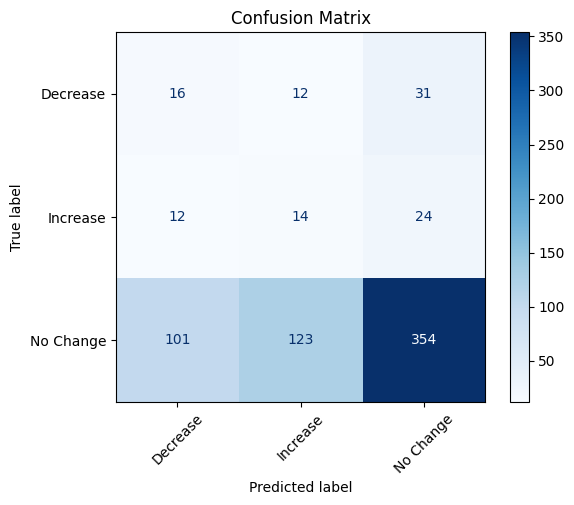


Classification Report:
              precision    recall  f1-score   support

    Decrease       0.12      0.27      0.17        59
    Increase       0.09      0.28      0.14        50
   No Change       0.87      0.61      0.72       578

    accuracy                           0.56       687
   macro avg       0.36      0.39      0.34       687
weighted avg       0.75      0.56      0.63       687



In [32]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred, labels=range(len(label_encoder.classes_)))
print(cm)

print()
# display Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

print()
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

## Iterpretation of Results

- "No Change" is the dominant category and is predicted with relatively high accuracy and precision.
- Categories "Decrease" and "Increase" are misclassified more often, with low precision and recall, despite training the model with a 10-fold `StratifiedKFold` strategy that preserves the percentage of samples for each category.
- This suggesting that this type of model struggles to distinguish between these categories due to the fewer samples.
